In [25]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import make_scorer
import xgboost as xgb

In [3]:
data = pd.read_csv('data/train.csv')

In [4]:
data.dropna(inplace=True)

In [5]:
freq_encoding = data['sub_area'].value_counts() / len(data)
data['sub_area'] = data['sub_area'].map(freq_encoding)
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [6]:
def label_encode_categorical(data):
    label_encoder = LabelEncoder()

    for column in data.select_dtypes(include=['object', 'category']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    data = data.drop(columns=data.select_dtypes(include=['object', 'category']).columns)

    for column in data.select_dtypes(include=['datetime']).columns:
        data[column] = data[column].dt.month
        data[column] = data[column].apply(lambda x: 'supper' if x in [3, 4, 5] else
                                                       ('summer' if x in [6, 7, 8] else
                                                       ('autumn' if x in [9, 10, 11] else 'winter')))

    return data

In [7]:
processed_data = label_encode_categorical(data)

In [8]:
processed_data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
8056,8059,supper,11,11.0,2.0,5.0,2.0,1907.0,1.0,12.0,...,339,135,26,133,207,1,89,161,10,2750000
8154,8157,supper,45,27.0,6.0,9.0,1.0,1970.0,2.0,6.0,...,2,1,0,3,8,1,0,19,3,7100000
8287,8290,summer,77,50.0,3.0,5.0,2.0,1957.0,3.0,8.0,...,214,85,21,48,89,1,54,146,12,11700000
8387,8390,summer,56,29.0,5.0,16.0,5.0,1987.0,2.0,10.0,...,74,32,8,19,34,0,10,121,7,10400000
8391,8394,summer,31,21.0,5.0,9.0,5.0,1962.0,1.0,5.0,...,99,43,8,17,41,1,18,93,5,6200000


In [9]:
data_one_hot = pd.get_dummies(processed_data, columns=['timestamp'])

In [10]:
data_one_hot.head()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,timestamp_autumn,timestamp_summer,timestamp_supper,timestamp_winter
8056,8059,11,11.0,2.0,5.0,2.0,1907.0,1.0,12.0,3.0,...,207,1,89,161,10,2750000,False,False,True,False
8154,8157,45,27.0,6.0,9.0,1.0,1970.0,2.0,6.0,3.0,...,8,1,0,19,3,7100000,False,False,True,False
8287,8290,77,50.0,3.0,5.0,2.0,1957.0,3.0,8.0,2.0,...,89,1,54,146,12,11700000,False,True,False,False
8387,8390,56,29.0,5.0,16.0,5.0,1987.0,2.0,10.0,2.0,...,34,0,10,121,7,10400000,False,True,False,False
8391,8394,31,21.0,5.0,9.0,5.0,1962.0,1.0,5.0,3.0,...,41,1,18,93,5,6200000,False,True,False,False


In [17]:
X, y = data_one_hot.drop(['id','price_doc'], axis=1), data_one_hot['price_doc']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
def rmsle(y_true, y_pred):
    # Clip predictions and true values to avoid log(0)
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred))**2))

# Create a scorer
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Example data (assuming X and y are predefined)
# X = your_features
# y = your_target

# Initialize the model
model = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Set up cross-validation (e.g., KFold with 5 splits)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get RMSLE scores
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring=rmsle_scorer)
model.fit(X_train_scaled, y_train)

# Permutation Feature Importance
result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)

/var/folders/qv/w_5nwf1d0452smw6s0s6sfh80000gp/T/ipykernel_1573/1852049743.py:3: RuntimeWarning: invalid value encountered in log1p
  return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred))**2))


array([-0.6286645 , -0.57076493, -0.60886188, -0.60543789, -0.59865105])

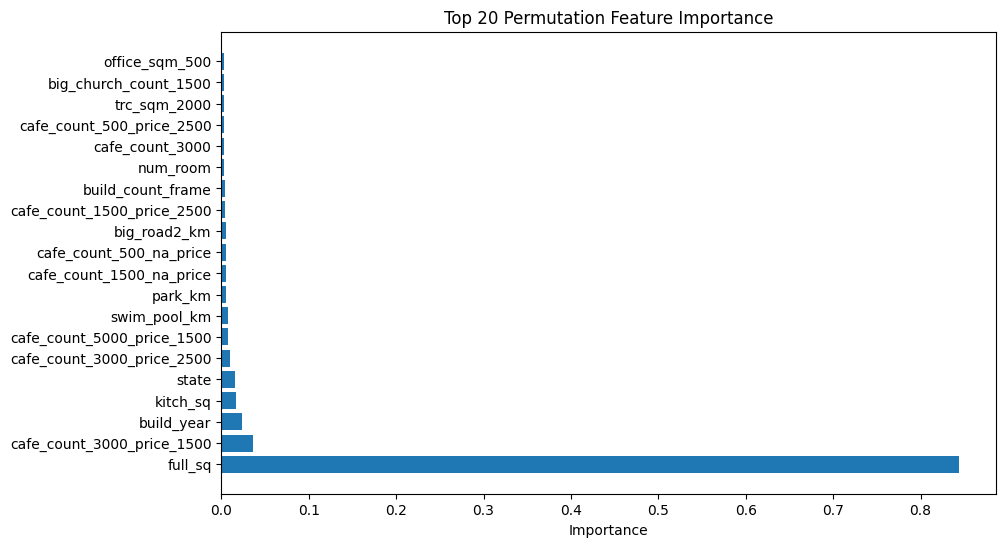

In [27]:
importance = result.importances_mean
sorted_idx = importance.argsort()[::-1]

sorted_feature_names = X.columns[sorted_idx]
sorted_importance = importance[sorted_idx]

top_20_feature_names = sorted_feature_names[:20]
top_20_importance = sorted_importance[:20]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_20_feature_names)), top_20_importance)
plt.yticks(range(len(top_20_feature_names)), top_20_feature_names)
plt.xlabel('Importance')
plt.title('Top 20 Permutation Feature Importance')
plt.show()

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [52]:
print(X_train_scaled.shape)
X_valid_scaled.shape

(21329, 275)


(9142, 275)

In [55]:
randForest_reg = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42, n_jobs=-1)

with tqdm(total=100, desc="Training Progress", ncols=100) as pbar:
    start_time = time.time()
    randForest_reg.fit(X_train_scaled, y_train)
    end_time = time.time()

Training Progress:   0%|                                                    | 0/100 [00:50<?, ?it/s]


In [56]:
coef = randForest_reg.feature_importances_

In [58]:
x

2901223.9926785147


,Importance
full_sq,0.382409
cafe_count_2000,0.042243
office_sqm_5000,0.022078
cafe_count_3000,0.021977
id,0.017111
...,...
mosque_count_1500,0.000040
mosque_count_2000,0.000026
build_count_foam,0.000023
mosque_count_500,0.000014


In [ ]:
def train_validate_report(model, X_train_scaled=X_train_scaled, y_train=y_train, X_valid_scaled=X_valid_scaled, y_valid=y_valid, feature_names=data.columns[:-1], forest=False):
    model.fit(X_train_scaled, y_train)
    print("loss=%f" % np.sqrt(mean_squared_error(y_valid, model.predict(X_valid_scaled))))
    coef = model.feature_importances_ if forest else model.coef_
    coef_name = "Importances" if forest else "Coef"
    return pd.DataFrame(coef, feature_names, columns=[coef_name]).sort_values(by=coef_name, ascending=False)

In [57]:
randForest_reg.oob_score_

0.6264376827584718

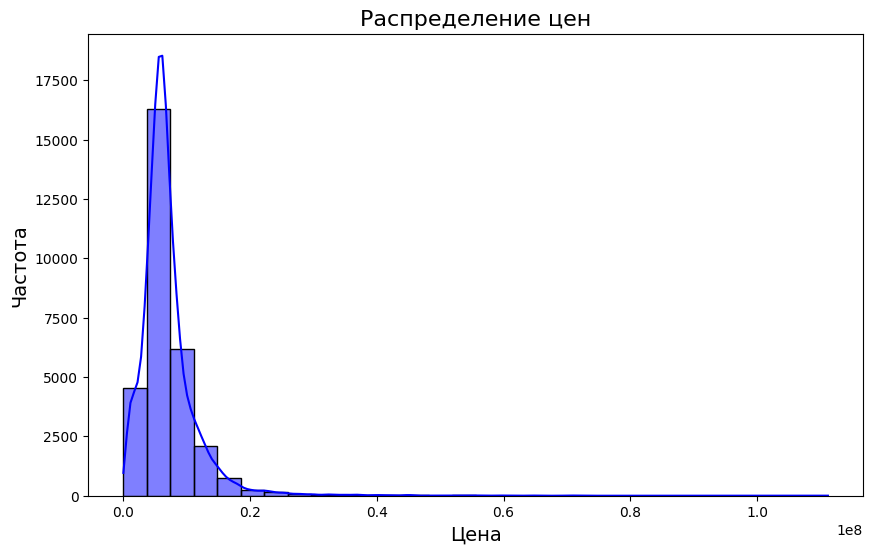

In [59]:
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, bins=30, color='blue')

# Настройки графика
plt.title('Распределение цен', fontsize=16)
plt.xlabel('Цена', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.show()

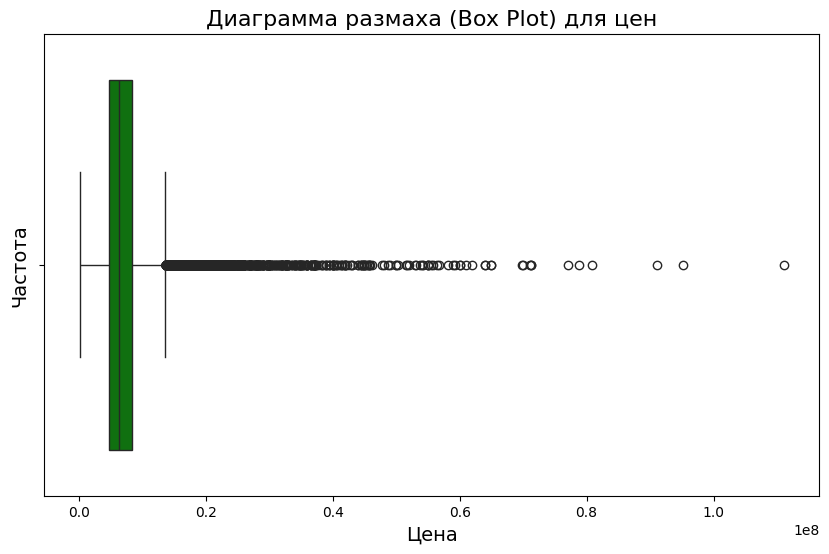

In [61]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=y, color='green')

# Настройки графика
plt.title('Диаграмма размаха (Box Plot) для цен', fontsize=16)
plt.xlabel('Цена', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.show()